# Weight distribution analysis

This notebook is used to visualise and (attempt to) interpret the experimental results from the `subset_training.py` script.

In [1]:
import sys
from pathlib import Path

import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

In [2]:
# Set the experiment results directory
PROJECT_DIR = Path.cwd().parent
CODE_DIR = PROJECT_DIR / "code"

# Add the project's `code` directory to the Python path
if CODE_DIR not in sys.path:
    sys.path.insert(0, str(CODE_DIR))

## Visualise Losses

In [3]:
N_SUBSETS = 10
N_EPOCHS = 100
DATASET = "small"  # "allsizes", "small", "medium", "large"
VERSION = "v1"

RESULTS_DIR = (
    PROJECT_DIR
    / "exp_results"
    / f"subset_training_{DATASET}"
    / f"{N_SUBSETS}_models_{N_EPOCHS}_epochs_{VERSION}"
)

# Load losses
train_losses = torch.load(RESULTS_DIR / f"train_losses_{N_EPOCHS}_epochs.pt")
val_losses = torch.load(RESULTS_DIR / f"val_losses_{N_EPOCHS}_epochs.pt")

assert train_losses.shape == val_losses.shape == (N_SUBSETS, N_EPOCHS)

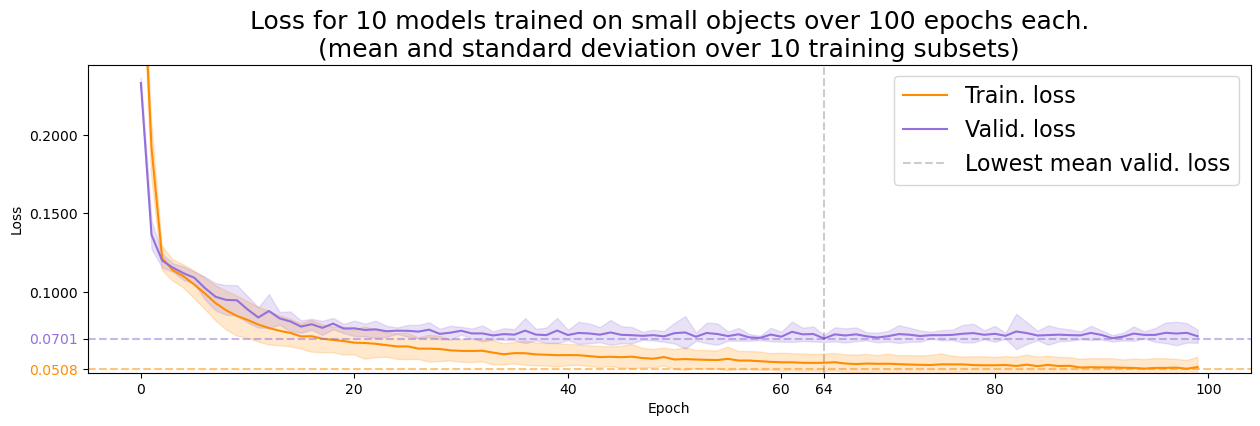

In [4]:
# Compute mean and standard deviation
train_losses_mean = train_losses.mean(dim=0)
train_losses_std = train_losses.std(dim=0)
val_losses_mean = val_losses.mean(dim=0)
val_losses_std = val_losses.std(dim=0)

# Compute minima
min_val_loss = val_losses_mean.min()
min_train_loss = train_losses_mean.min()

# Plot training and validation loss
plt.figure(figsize=(15, 4))
plt.plot(train_losses_mean, label="Train. loss", color="darkorange")
plt.plot(val_losses_mean, label="Valid. loss", color="mediumpurple")
plt.fill_between(
    range(N_EPOCHS),
    train_losses_mean - train_losses_std,
    train_losses_mean + train_losses_std,
    alpha=0.2,
    color="darkorange",
)
plt.fill_between(
    range(N_EPOCHS),
    val_losses_mean - val_losses_std,
    val_losses_mean + val_losses_std,
    alpha=0.2,
    color="mediumpurple",
)

# Labels and legend
plt.axhline(y=min_val_loss, linestyle="--", alpha=0.5, color="mediumpurple")
plt.axhline(y=min_train_loss, linestyle="--", alpha=0.5, color="darkorange")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title(
    f"Loss for {N_SUBSETS} models trained on {DATASET} objects over {N_EPOCHS} epochs each.\n"
    f"(mean and standard deviation over {N_SUBSETS} training subsets)",
    fontsize=18,
)

# Combine existing y-ticks with mininum values
yticks = [
    ytick
    for ytick in list(plt.yticks()[0])
    if ytick > max(min_val_loss, min_train_loss)
]
new_yticks = sorted(yticks + [min_val_loss, min_train_loss])
plt.yticks(new_yticks, [f"{ytick:.4f}" for ytick in new_yticks])

for tick_label in plt.gca().get_yticklabels():
    if tick_label.get_text() == f"{min_val_loss:.4f}":
        tick_label.set_color("mediumpurple")
    elif tick_label.get_text() == f"{min_train_loss:.4f}":
        tick_label.set_color("darkorange")

xticks = sorted(
    [n for n in list(plt.xticks()[0]) if n >= 0 and n <= N_EPOCHS]
    + [val_losses_mean.argmin().item()]
)
plt.xticks(xticks, [str(int(xtick)) for xtick in xticks])
plt.axvline(
    x=val_losses_mean.argmin(),
    linestyle="--",
    alpha=0.2,
    color="black",
    label=f"Lowest mean valid. loss",
)

plt.ylim(min(min_val_loss, min_train_loss) * 0.95, val_losses_mean.max() * 1.05)
plt.legend(fontsize=16)
plt.savefig(
    f"../plots/subset_training_{DATASET}_{N_SUBSETS}_models_{N_EPOCHS}_epochs_losses_{VERSION}.png",
    dpi=300,
)

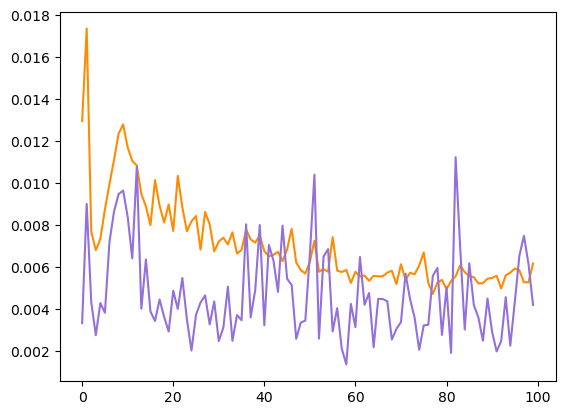

In [5]:
plt.plot(train_losses_std, label="Train. loss standard deviation",
         color="darkorange")
plt.plot(val_losses_std,   label="Valid. loss standard deviation",
         color="mediumpurple")

## Visualise Weights

In [6]:
RESOLUTIONS = [8, 16, 32, 64]

models = [torch.load(RESULTS_DIR / f"model_{i}.pt") for i in range(N_SUBSETS)]

# Load weights from disk
ts_weights = {
    res: torch.stack([model.ts_weights[str(res)].detach() for model in models])
    for res in RESOLUTIONS
}
ch_weights = {
    res: torch.stack([model.ch_weights[str(res)].detach() for model in models])
    for res in RESOLUTIONS
}
res_weights = torch.stack([model.res_weights.detach() for model in models])

### All weights

Finally, we plot the mean and "error bars" (indicating one standard deviation above and below the mean) for all weights, i.e. the time step, channel, and resolution weights.

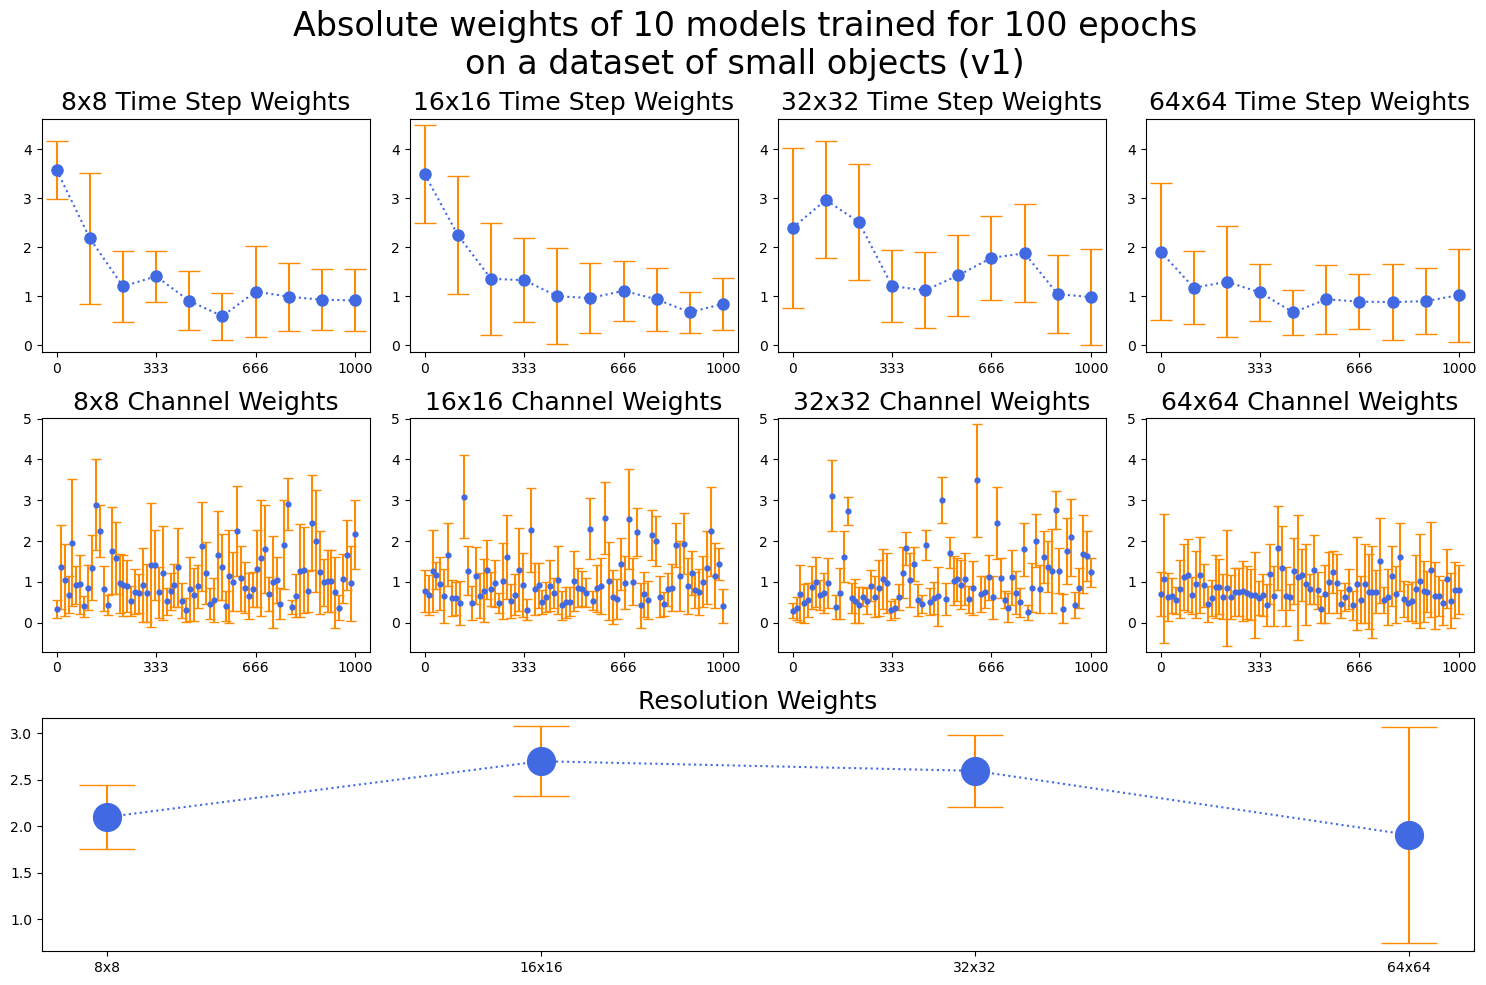

In [7]:
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(3, 4, figure=fig)

# Create subplots for the first two rows and a wide subplot for the last row
axs = [[fig.add_subplot(gs[i, j]) for j in range(4)] for i in range(2)]
axs.append([fig.add_subplot(gs[2, :])])


def plot_weights(
    ax,
    mean,
    std,
    title,
    xticklabels,
    marker_size=8,
    fmt=":o",
    ymin=-1.0,
    ymax=7.0,
):
    ax.errorbar(
        range(1, len(mean) + 1),
        mean,
        yerr=std,
        fmt=fmt,
        ms=marker_size,
        capsize=marker_size,
        ecolor="darkorange",
        color="royalblue",
    )
    ax.set_title(title, fontsize=18)
    ax.set_xticks(np.linspace(1, len(mean), 4))
    ax.set_xticklabels(xticklabels)
    ax.set_ylim(ymin - 0.03 * ymax, ymax * 1.03)


ts_and_ch_weights = [ts_weights, ch_weights]
marker_formats = [":o", "o"]
marker_sizes = [8, 3.5]

# Loop for time step and channel weights
for row, (weights, ms, fmt) in enumerate(
    zip(ts_and_ch_weights, marker_sizes, marker_formats)
):
    mean_all = torch.stack([weights[res].abs().mean(dim=0) for res in RESOLUTIONS])
    std_all = torch.stack([weights[res].abs().std(dim=0) for res in RESOLUTIONS])

    for col, res in enumerate(RESOLUTIONS):
        mean, std = mean_all[col], std_all[col]
        plot_weights(
            axs[row][col],
            mean,
            std,
            f"{res}x{res} {'Time Step' if row==0 else 'Channel'} Weights",
            np.linspace(0, 1000, 4, dtype=int),
            marker_size=ms,
            fmt=fmt,
            ymin=(mean_all - std_all).min().item(),
            ymax=(mean_all + std_all).max().item(),
        )

# Resolution weights
mean = res_weights.abs().mean(dim=0)
std = res_weights.abs().std(dim=0)
plot_weights(
    axs[2][0],
    mean,
    std,
    "Resolution Weights",
    ["8x8", "16x16", "32x32", "64x64"],
    marker_size=20,
    fmt=":o",
    ymin=(mean - std).min().item(),
    ymax=(mean + std).max().item(),
)

fig.suptitle(
    f"Absolute weights of {N_SUBSETS} models trained for {N_EPOCHS} epochs\n"
    f"on a dataset of {DATASET} objects ({VERSION})",
    fontsize=24,
)
plt.tight_layout()

plt.savefig(
    f"../plots/subset_training_{DATASET}_{N_SUBSETS}_models_{N_EPOCHS}_epochs_weights_{VERSION}.png",
    dpi=300,
)

'Total variance of weights: 24.469979286193848'

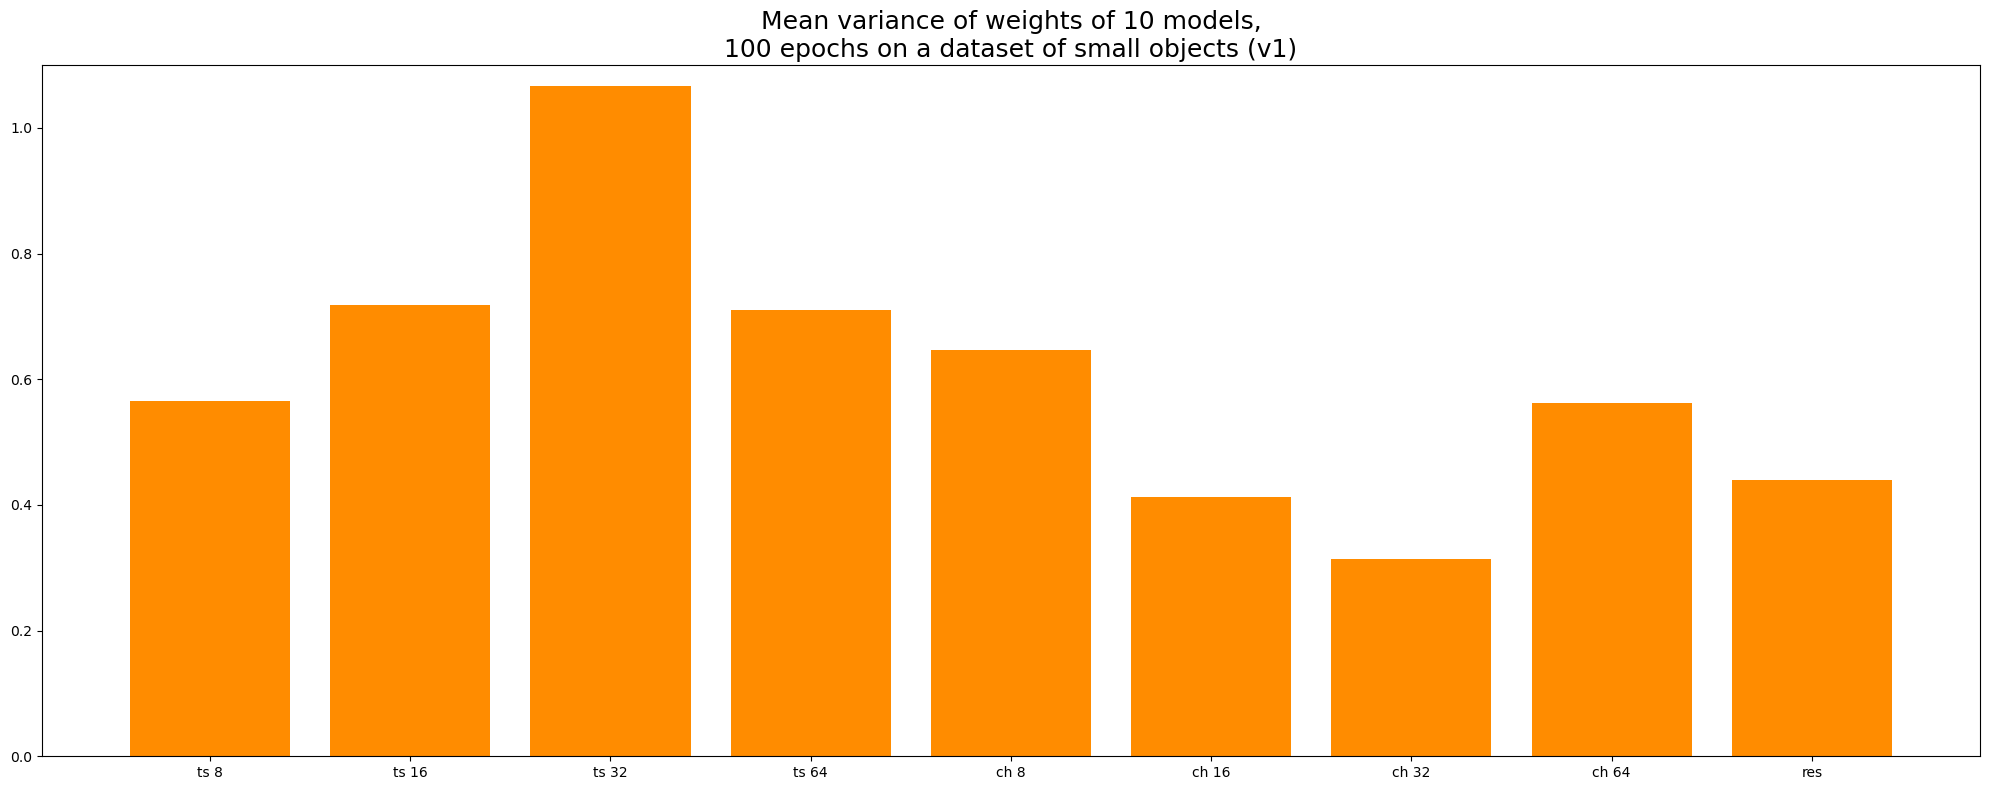

In [8]:
fig = plt.figure(figsize=(20, 8))

plt.bar(
    ["ts 8", "ts 16", "ts 32", "ts 64", "ch 8", "ch 16", "ch 32", "ch 64", "res"],
    [ts_weights[res].abs().var(dim=0).mean().item() for res in RESOLUTIONS]
    + [ch_weights[res].abs().var(dim=0).mean().item() for res in RESOLUTIONS]
    + [res_weights.abs().var(dim=0).mean().item()],
    color="darkorange",
)
plt.title(
    f"Mean variance of weights of {N_SUBSETS} models,\n"
    f"{N_EPOCHS} epochs on a dataset of {DATASET} objects ({VERSION})",
    fontsize=18,
)
plt.ylim(0, 1.1)
fig.tight_layout()

plt.savefig(
    f"../plots/subset_training_{DATASET}_{N_SUBSETS}_models_{N_EPOCHS}_epochs_variances_{VERSION}.png",
    dpi=300,
)

# Print total variance of weights
"Total variance of weights: " + str(
    sum(
        [ts_weights[res].var(dim=0).mean().item() for res in RESOLUTIONS]
        + [ch_weights[res].var(dim=0).mean().item() for res in RESOLUTIONS]
        + [res_weights.var(dim=0).mean().item()]
    )
)